In [ ]:
!pip install discretize==0.10.0 #differ from the 0.8.3
!pip install SimPEG==0.19
!pip install pymatsolver==0.2.0
!pip install utm==0.7.0
!pip install matplotlib==3.8.0 

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile
import utm
from discretize import TreeMesh, TensorMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

from SimPEG.utils import model_builder
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc
from SimPEG.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

mpl.rcParams.update({"font.size": 16})
# sphinx_gallery_thumbnail_number = 4

/tmp/ipykernel_3149752/3040355382.py:11: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG.utils import model_builder


In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile
import utm
from discretize import TreeMesh, TensorMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

from simpeg.utils import model_builder
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from simpeg import SolverLU as Solver

mpl.rcParams.update({"font.size": 16})
# sphinx_gallery_thumbnail_number = 4

In [2]:
from matplotlib.colors import Colormap
import pymatsolver
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)

In [4]:
from matplotlib.colors import Colormap
import pymatsolver
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)

Define the topology

In [5]:
x_topo, y_topo = np.meshgrid(
    np.linspace(-2000, 2000, 401), np.linspace(-2000, 2000, 62)
)

z_topo = np.zeros(x_topo.shape)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[x_topo, y_topo, z_topo]

topo_2d = np.unique(topo_xyz[:, [0, 2]], axis=0)

Define the survey configuration

In [6]:
# Define survey line parameters
survey_type = "dipole-dipole"
dimension_type = "2D"
data_type = "volt"
end_locations = np.r_[-350.0, 350.0]
station_separation = 25.0
num_rx_per_src = 24 #With Tx fixed, move Rx 24 times

# Generate source list for DC survey line
source_list = generate_dcip_sources_line(
    survey_type,
    data_type,
    dimension_type,
    end_locations,
    topo_2d,
    num_rx_per_src,
    station_separation,
)

# Define survey
survey = dc.survey.Survey(source_list, survey_type=survey_type)

/home/axu/anaconda3/lib/python3.9/site-packages/simpeg/electromagnetics/static/resistivity/survey.py:32: FutureWarning: Argument 'survey_type' is ignored and will be removed in future versions of SimPEG. Types of sources and their corresponding receivers are obtained from their respective classes, without the need to specify the survey type.
  warnings.warn(


Mesh Design

In [7]:
# Cell sizes
csx, csy = 5.0, 5.0
# Number of core cells in each direction
ncx, ncy = 200.0 , 45.0
# Number of padding cells to add in each direction
npad = 7
# Vectors of cell lengths in each direction with padding
hx_ = [(csx, npad, -1.5), (csx, ncx), (csx, npad, 1.5)]
hy_ = [(csy, npad, -1.5), (csy, ncy)]
# Create mesh and center it
mesh = TensorMesh([hx_, hy_], x0="CN")


In [8]:
mesh

TensorMesh: 11,128 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    214       -741.29        741.29      5.00     85.43    1.50
   y     52       -466.29          0.00      5.00     85.43    1.50

/tmp/ipykernel_3152239/2300458564.py:1: FutureWarning: TensorMesh.plotGrid has been deprecated, please use TensorMesh.plot_grid. It will be removed in version 1.0.0 of discretize.
  mesh.plotGrid()


<AxesSubplot:xlabel='x1', ylabel='x2'>

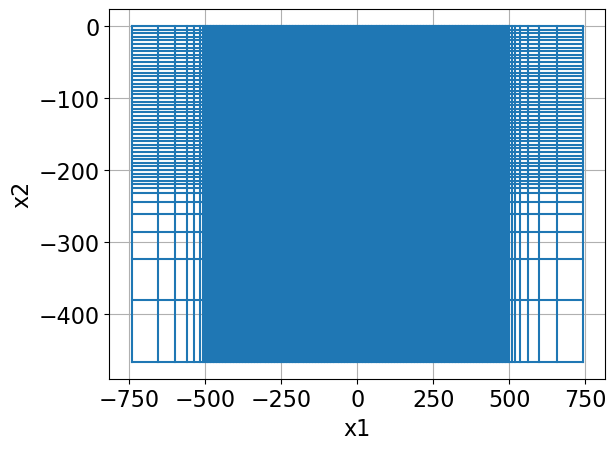

In [9]:
mesh.plotGrid()

Define the true conductivity model

Case 3.1

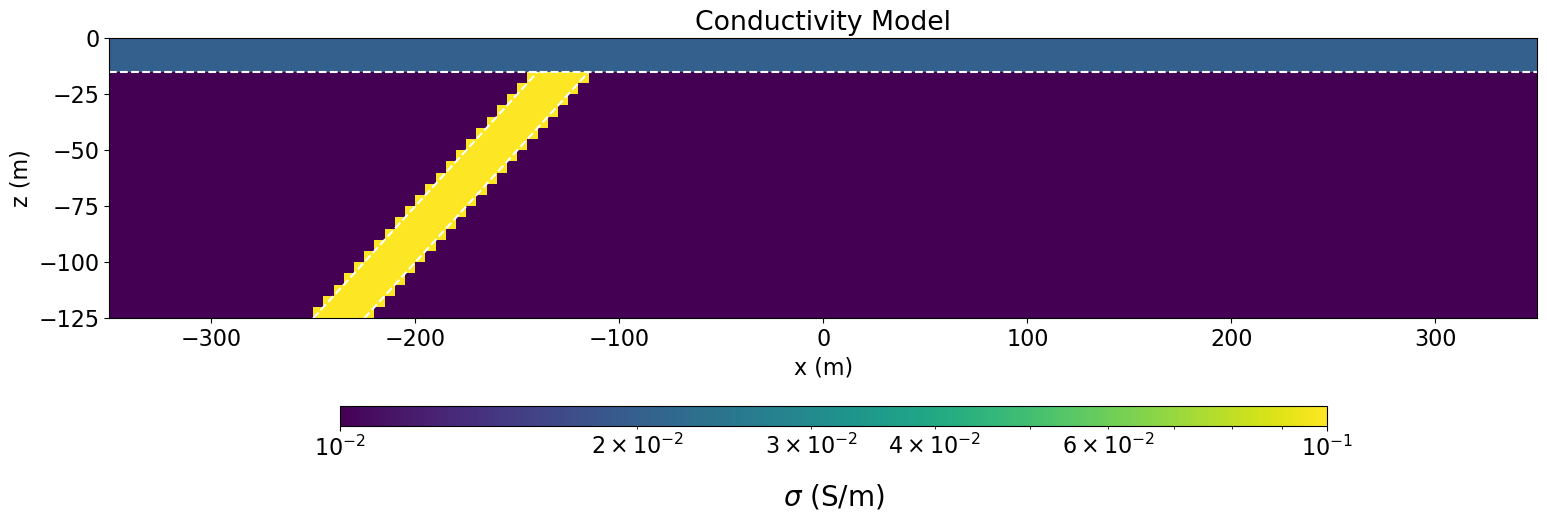

In [10]:
# Define conductivity model in S/m

background_conductivity = 1e-2
layer_1 = 2e-2
dike_ = 1e-1

# Find active cells in forward modeling (cell below surface)
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum()) # Number of cells below the surface <= ind_active.shape[0]

# Define model
conductivity_model = background_conductivity * np.ones(nC)

xlim_layer_1 = np.r_[-740, 740]
zlim_layer_1 = np.r_[-15, 0]

layer1 = (
    (mesh.gridCC[:, 0] >= xlim_layer_1.min()) & (mesh.gridCC[:, 0] <= xlim_layer_1.max()) &
    (mesh.gridCC[:, 1] >= zlim_layer_1.min()) & (mesh.gridCC[:, 1] <= zlim_layer_1.max())
)

conductivity_model[layer1] = layer_1

dike = ((mesh.gridCC[:, 1] <=-15)&(mesh.gridCC[:, 1] >=-125)&
    (mesh.gridCC[:, 1] >=  (mesh.gridCC[:, 0]+100)) & (mesh.gridCC[:, 1] <= (mesh.gridCC[:, 0]+125))
)#CHANGE!!!

conductivity_model[dike] = dike_
# Plot Conductivity Model
fig = plt.figure(figsize=(21, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
norm = LogNorm(vmin=1e-2, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model, ax=ax1, grid=False, pcolor_opts={"norm": norm}
)
ax1.set_xlim(-350, 350)
ax1.set_ylim(-125, 0)
ax1.plot(np.linspace(-350,350, 1000), -15*np.ones(1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)-125, np.linspace(-125,-15, 1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)-100, np.linspace(-125,-15, 1000), "w--")
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.25, -.1, 0.47, 0.05])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="horizontal")
cbar.set_label("$\sigma$ (S/m)", labelpad=15, size=20)

plt.show()

Case 3.2

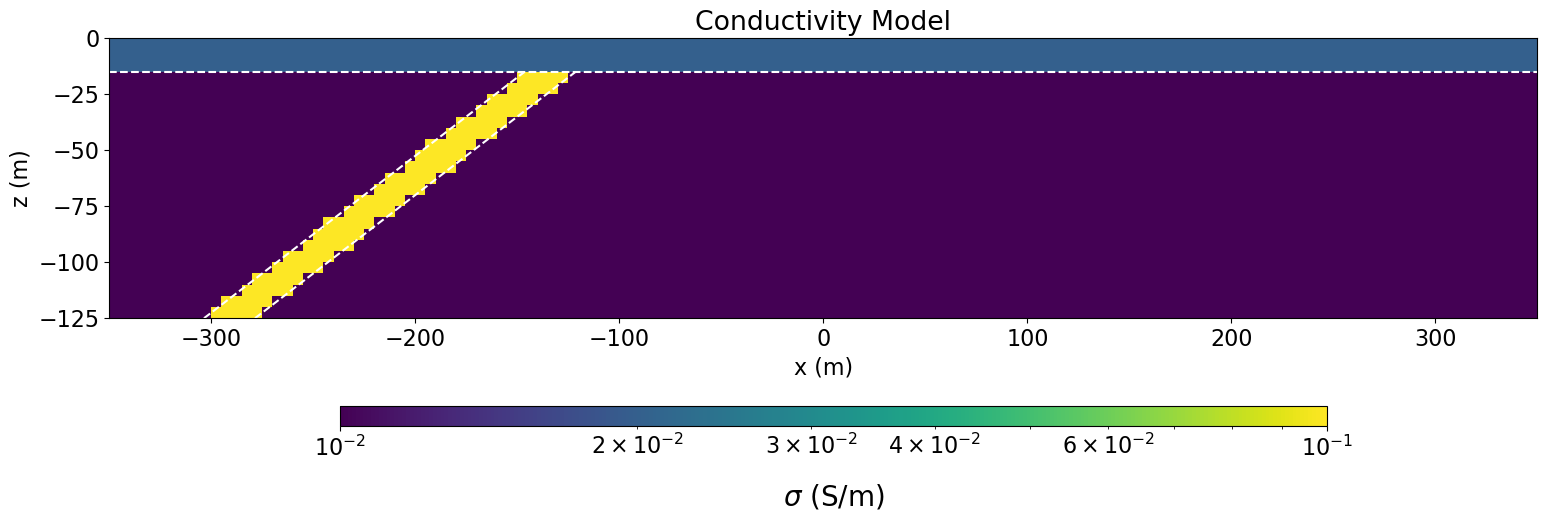

In [19]:
# Define conductivity model in S/m

background_conductivity = 1e-2
layer_1 = 2e-2
dike_ = 1e-1

# Find active cells in forward modeling (cell below surface)
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum()) # Number of cells below the surface <= ind_active.shape[0]

# Define model
conductivity_model = background_conductivity * np.ones(nC)

xlim_layer_1 = np.r_[-740, 740]
zlim_layer_1 = np.r_[-15, 0]

layer1 = (
    (mesh.gridCC[:, 0] >= xlim_layer_1.min()) & (mesh.gridCC[:, 0] <= xlim_layer_1.max()) &
    (mesh.gridCC[:, 1] >= zlim_layer_1.min()) & (mesh.gridCC[:, 1] <= zlim_layer_1.max())
)

conductivity_model[layer1] = layer_1

dike = ((mesh.gridCC[:, 1] <=-15)&(mesh.gridCC[:, 1] >=-125)&
    (mesh.gridCC[:, 1] >=  .7*(mesh.gridCC[:, 0]+100)) & (mesh.gridCC[:, 1] <= .7*(mesh.gridCC[:, 0]+125))
)#CHANGE!!!
conductivity_model[dike] = dike_
# Plot Conductivity Model
fig = plt.figure(figsize=(21, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
norm = LogNorm(vmin=1e-2, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model, ax=ax1, grid=False, pcolor_opts={"norm": norm}
)
ax1.set_xlim(-350, 350)
ax1.set_ylim(-125, 0)
ax1.plot(np.linspace(-350,350, 1000), -15*np.ones(1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)/.7-125, np.linspace(-125,-15, 1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)/.7-100, np.linspace(-125,-15, 1000), "w--")
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.25, -.1, 0.47, 0.05])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="horizontal")
cbar.set_label("$\sigma$ (S/m)", labelpad=15, size=20)

plt.show()

Case 3.3

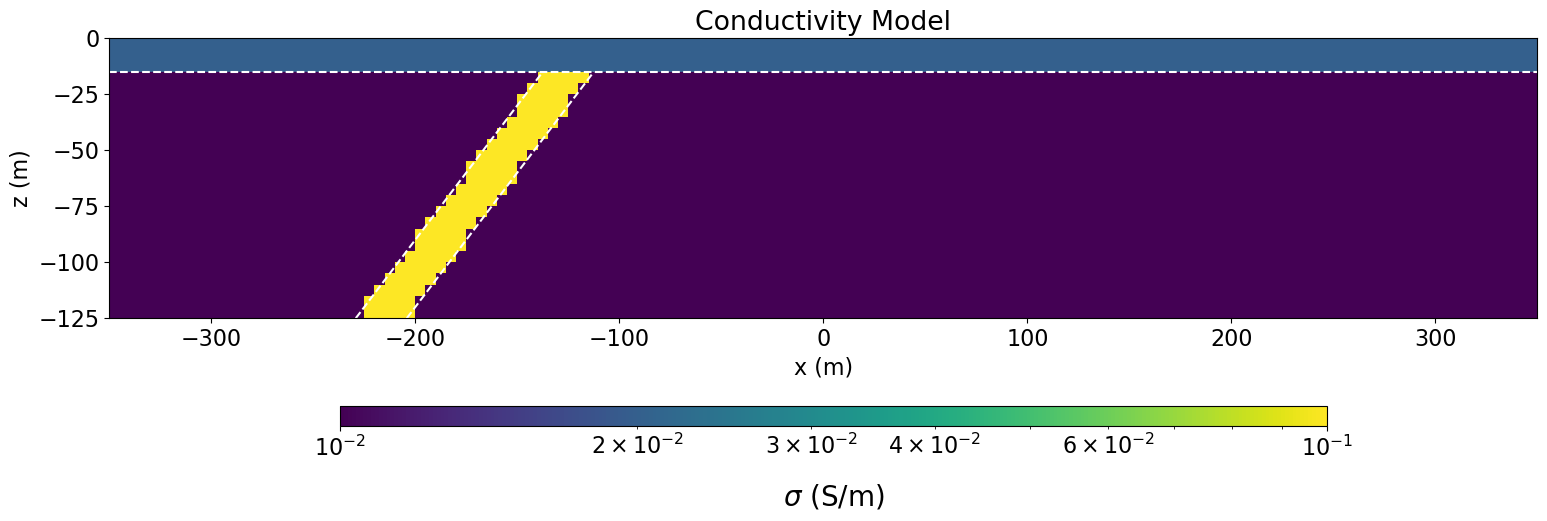

In [27]:
# Define conductivity model in S/m

background_conductivity = 1e-2
layer_1 = 2e-2
dike_ = 1e-1

# Find active cells in forward modeling (cell below surface)
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum()) # Number of cells below the surface <= ind_active.shape[0]

# Define model
conductivity_model = background_conductivity * np.ones(nC)

xlim_layer_1 = np.r_[-740, 740]
zlim_layer_1 = np.r_[-15, 0]

layer1 = (
    (mesh.gridCC[:, 0] >= xlim_layer_1.min()) & (mesh.gridCC[:, 0] <= xlim_layer_1.max()) &
    (mesh.gridCC[:, 1] >= zlim_layer_1.min()) & (mesh.gridCC[:, 1] <= zlim_layer_1.max())
)

conductivity_model[layer1] = layer_1

dike = ((mesh.gridCC[:, 1] <=-15)&(mesh.gridCC[:, 1] >=-125)&
    (mesh.gridCC[:, 1] >=  1.2*(mesh.gridCC[:, 0]+100)) & (mesh.gridCC[:, 1] <= 1.2*(mesh.gridCC[:, 0]+125))
)#CHANGE!!!
conductivity_model[dike] = dike_
# Plot Conductivity Model
fig = plt.figure(figsize=(21, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
norm = LogNorm(vmin=1e-2, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model, ax=ax1, grid=False, pcolor_opts={"norm": norm}
)
ax1.set_xlim(-350, 350)
ax1.set_ylim(-125, 0)
ax1.plot(np.linspace(-350,350, 1000), -15*np.ones(1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)/1.2-125, np.linspace(-125,-15, 1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)/1.2-100, np.linspace(-125,-15, 1000), "w--")
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.25, -.1, 0.47, 0.05])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="horizontal")
cbar.set_label("$\sigma$ (S/m)", labelpad=15, size=20)

plt.show()

Case_4

In [6]:
log_scale_ = np.flip(np.linspace(np.log10(1e-3), np.log10(2e-2),45))
layer_values=10**log_scale_

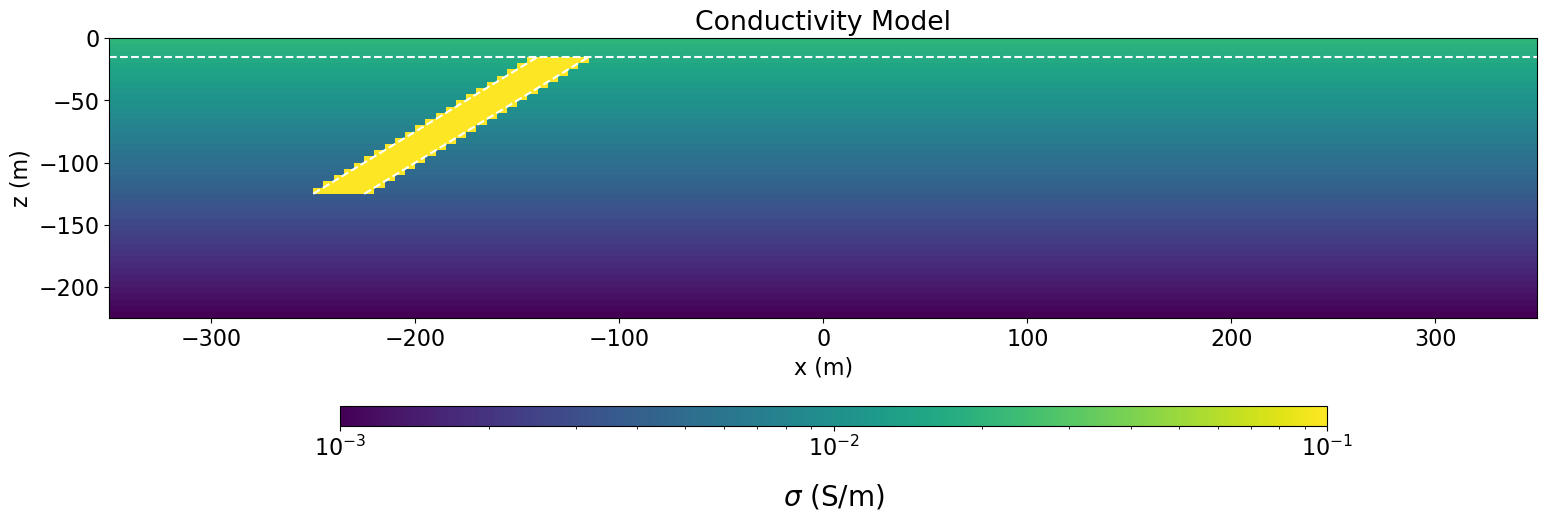

In [7]:
# Define conductivity model in S/m

background_conductivity = 1e-3
dike_ = 1e-1

# Find active cells in forward modeling (cell below surface)
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum()) # Number of cells below the surface <= ind_active.shape[0]

# Define model
conductivity_model = background_conductivity * np.ones(nC)

for layer_number in range(45):
    layer_ = layer_values[layer_number]
    xlim_layer_1 = np.r_[-740, 740]
    zlim_layer_1 = np.r_[-(layer_number+1)*5, -layer_number*5]

    _layer = (
        (mesh.gridCC[:, 0] >= xlim_layer_1.min()) & (mesh.gridCC[:, 0] <= xlim_layer_1.max()) &
        (mesh.gridCC[:, 1] >= zlim_layer_1.min()) & (mesh.gridCC[:, 1] <= zlim_layer_1.max())
    )

    conductivity_model[_layer] = layer_
    

layer1 = (
    (mesh.gridCC[:, 0] >= 500) | (mesh.gridCC[:, 0] <= -500))

conductivity_model[layer1] = background_conductivity

dike = ((mesh.gridCC[:, 1] <=-15)&(mesh.gridCC[:, 1] >=-125)&
    (mesh.gridCC[:, 1] >=  (mesh.gridCC[:, 0]+100)) & (mesh.gridCC[:, 1] <= (mesh.gridCC[:, 0]+125))
)

conductivity_model[dike] = dike_
# Plot Conductivity Model
fig = plt.figure(figsize=(21, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model, ax=ax1, grid=False, pcolor_opts={"norm": norm}
)
ax1.set_xlim(-350, 350)
ax1.set_ylim(-225, 0)
ax1.plot(np.linspace(-350,350, 1000), -15*np.ones(1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)-125, np.linspace(-125,-15, 1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)-100, np.linspace(-125,-15, 1000), "w--")
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.25, -.1, 0.47, 0.05])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="horizontal")
cbar.set_label("$\sigma$ (S/m)", labelpad=15, size=20)

plt.show()

In [28]:
simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, sigmaMap=maps.IdentityMap(mesh), solver=Solver, storeJ=True
)
# Predict the data by running the simulation. The data are the raw voltage in
# units of volts.
dpred = simulation.dpred(conductivity_model)

Store toplogy and measurements to the topo_xyz.txt and dc_data.obs respectively.

In [36]:
write_output = True

In [ ]:
dir_path = './Case_3.1_truncated_z_225'
os.mkdir(dir_path)

In [23]:
if write_output:

    # Add 5% Gaussian noise to each datum for Case1.X and Case2.X
    np.random.seed(225)
    std = 0.05 * np.abs(dpred) 
    dc_noise = std * np.random.randn(len(dpred))
    dobs = dpred + dc_noise

    source_list = generate_dcip_sources_line(
        survey_type,
        data_type,
        dimension_type,
        end_locations,
        topo_xyz,
        num_rx_per_src,
        station_separation,
    )
    survey_original = dc.survey.Survey(source_list)

    data_obj = data.Data(survey_original, dobs=dobs, standard_deviation=std)
    fname = dir_path + "/dc_data.obs"
    write_dcip2d_ubc(fname, data_obj, "volt", "dobs")

    fname = dir_path + "/topo_xyz.txt"
    np.savetxt(fname, topo_xyz, fmt="%.4e")

TypeError: Object must be an instance of BaseSurvey for survey

In [22]:
if write_output:

    # Add 5% Gaussian noise to each datum for Case1.X and Case2.X
    np.random.seed(225)
    # np.random.seed(0) #CHANGE!!!!!
    # np.random.seed(10) #CHANGE!!!!!
    std = 0.05 * np.abs(dpred) #CHANGE!!!
    dc_noise = std * np.random.randn(len(dpred))
    dobs = dpred + dc_noise

    source_list = generate_dcip_sources_line(
        survey_type,
        data_type,
        dimension_type,
        end_locations,
        topo_xyz,
        num_rx_per_src,
        station_separation,
    )
    survey_original = dc.survey.Survey(source_list)

    data_obj = data.Data(survey_original, dobs=dobs, standard_deviation=std)
    # fname = dir_path + "/dc_data.obs"
    # write_dcip2d_ubc(fname, data_obj, "volt", "dobs")

    # fname = dir_path + "/topo_xyz.txt"
    # np.savetxt(fname, topo_xyz, fmt="%.4e")

Text(0.5, 1.0, 'np.abs((dpred-dpred_)/dpred')

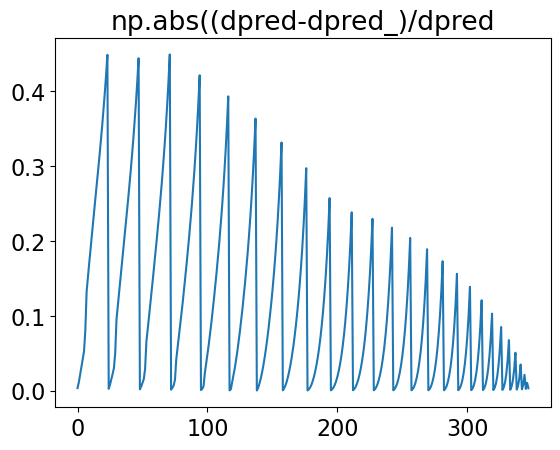

In [25]:
plt.plot(np.abs((dpred-dpred_)/dpred_))
plt.title('np.abs((dpred-dpred_)/dpred')

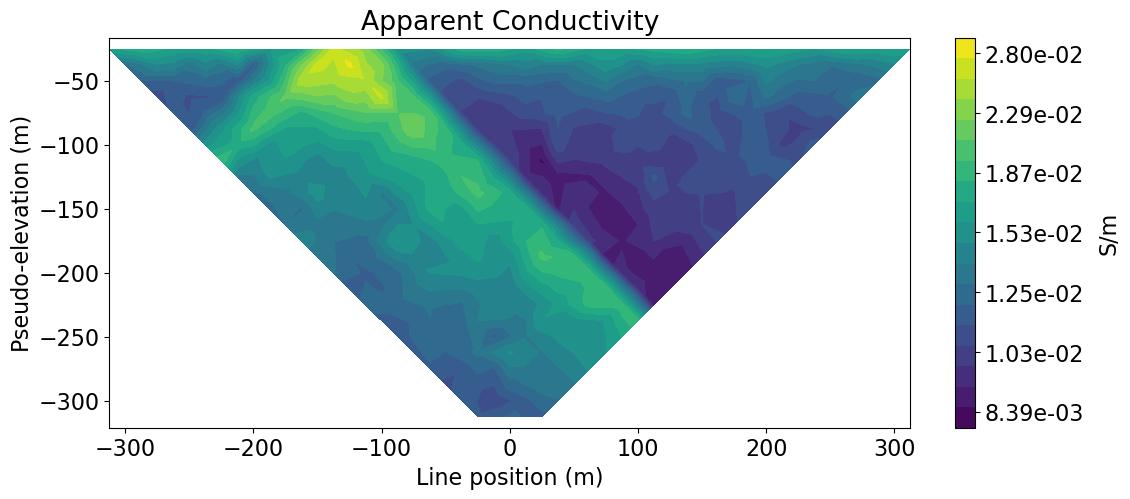

In [23]:
# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    data_obj,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    data_type="apparent conductivity",
    cbar_label="S/m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.viridis},
)
ax1.set_title("Apparent Conductivity")
plt.show()

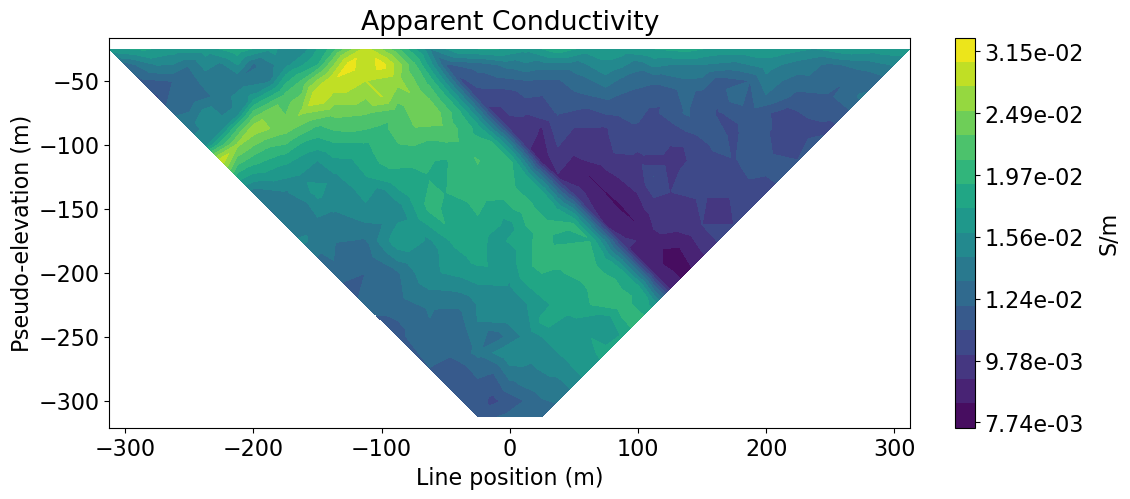

In [75]:
# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    data_obj,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    data_type="apparent conductivity",
    cbar_label="S/m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.viridis},
)
ax1.set_title("Apparent Conductivity")
plt.show()

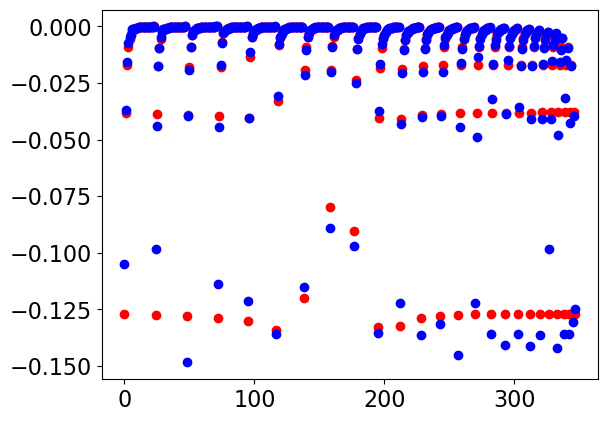

In [19]:
plt.plot(dpred,'ro')
plt.plot(dobs, 'bo')